<a href="https://colab.research.google.com/github/PaulToronto/IBM---AI-Engineering-Professional-Certificate/blob/main/1_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.3 Classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

import time

from sklearn.tree import DecisionTreeRegressor

## 1.3.1 K-Nearest Neighbours

### 1.3.1.1 Introduction to Classification

- A supervised learning approach
- Categorizing some unknown items into a discrete set of categories or **classes**
- The target attribute is a categorical variable
- Classification can be:
    - Binary classification
    - Multiclass classification
- Use cases
    - Which category a customer belongs to
    - Whether a customer switches to another provider/brand
    - Whether a customer responds to a particular advertising campaign
- Some classification algorithms
    - Decision Trees (ID3, C4.5, C5.0)
    - Naive Bayes
    - Linear Discriminant Analysis
    - k-Nearest Neighbour
    - Logistic Regression
    - Neural Networks
    - Support Vector Machines (SVM)

### 1.3.1.2 k-Nearest Neighbours

In [2]:
data_url = 'https://s3-api.us-geo.objectstorage.softlayer.net/'
data_url += 'cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv'

df = pd.read_csv(data_url)
df = df[(df.age < 65) & (df.income < 225)][:50]
df = df[~(df.index == 8)]
df = df[['age', 'income', 'custcat']]
df.reset_index(inplace=True, drop=True)
df.head(8)

,age,income,custcat
0,44,64.0,1
1,33,136.0,4
2,52,116.0,3
3,33,33.0,1
4,30,30.0,3
5,39,78.0,3
6,22,19.0,2
7,35,76.0,4


- We went to predict the `custcat` for a customer whose `age` is 50 and whose income is `166`
- If we choose `k=1`, we can see that the nearest neighbour is in class 4
- If we choose `k=5`, and do a majority vote, we get class 3

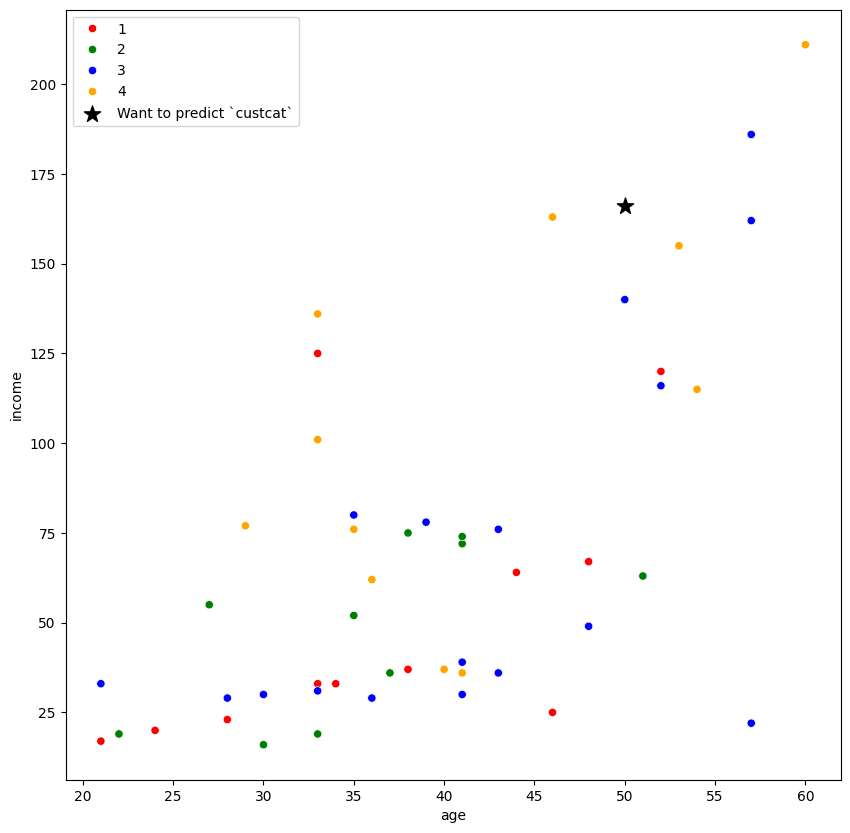

In [3]:
plt.figure(figsize=(10, 10))
sns.scatterplot(df,
                x='age',
                y='income',
                hue='custcat',
                palette=['red', 'green', 'blue', 'orange'])
plt.scatter(50, 166, marker='*', s=150, c='black', label='Want to predict `custcat`')
plt.legend();

#### What is k-Nearest Neighbor (KNN)?

- It is a classification algorithm that takes a bunch of labeled points and uses them to learn how to classify other points
- The algorithm classifies cases based on their similarity to other cases
- In KNN, data points that are near each other are said to be neighbors
- Similar cases with the same class labels are near each other
    - Thus, the distance between two cases is a measure of their dissimilarity
- Different ways to calculate the similarity, or conversely, the dissimilarity or distance of two data points
    - Euclidean distance is only one way

#### The k-Nearest Neighbors Algorithm

1. Pick a value for `k`
2. Calculate the distance of the unknown case from all cases
3. Search for the `k` observations in the training data that are *nearest* to the unknown data point
4. Predict the response of the unknown data point using the most popular response value from the k-nearest neighbors


#### Euclidean Distance

$$
Dis(x_1, x_2) = \sqrt{\sum_{i=0}^{n}\left(x_{1i} - x_{2i}\right)^{2}}
$$

In [4]:
df[:2]

,age,income,custcat
0,44,64.0,1
1,33,136.0,4


$$
\begin{align}
Dis(x_1, x_2) &= \sqrt{\left(44 - 33\right)^2 + \left(64 - 136\right)^{2}} \\
&= \sqrt{11^{2} - (-72)^{2}} \\
&= \sqrt{121 + 5184} \\
&= \sqrt{5305} \\
&= 72.8
\end{align}
$$

In [5]:
dis = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2))

row1 = df.iloc[0, :-1]
row2 = df.iloc[1, :-1]
dis(row1, row2)

72.83543093852057

In [6]:
# suppose the third parameter is education
row1 = np.array([34, 190, 3])
row2 = np.array([30, 200, 8])

dis(row1, row2)

11.874342087037917

#### How to choose `k`

- A low value of `k` causes a highly complex model, which might result in overfitting
- A high value of `k`, then the model becomes overly generalized
- How to choose `k`
    - Reserve a part of your data for testing the accuracy of your model
    - Plot `accuracy` vs. `k` for a number of values of `k`

#### Computing continuous targets using KNN

- KNN can also be used for regression
- In this situation, instead of a majority vote, use the mean or median to obtain the predicted value

### 1.3.1.3 Evaluation Metrics in Classification

In [7]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y_predicted = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Jaccard Index

- This score is between 0 and 1, with 1 being a perfect match

$$
J\left(y, \widehat{y}\right) = \frac{\lvert y \cap \widehat{y} \rvert}{\lvert y \cup \widehat{y} \rvert} = \frac{\lvert y \cap \widehat{y} \rvert}{\lvert y \rvert + \vert \widehat{y} \rvert - \lvert y \cap \widehat{y} \rvert}
$$

In [8]:
jaccard_score(y_true, y_predicted, average='micro')

0.6

In [9]:
y_intersect_y_hat = (y_true == y_predicted).sum()
len_y = len(y_true)
len_y_hat = len(y_predicted)

print(y_intersect_y_hat, len_y, len_y_hat)

J = y_intersect_y_hat / (len_y + len_y_hat - y_intersect_y_hat)
J

30 40 40


0.6

#### Confusion Matrix

In [10]:
print(np.array([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


In [11]:
cm = confusion_matrix(y_true, y_predicted)
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
tp = cm[1, 1]
np.array([[tn, fp],
          [fn, tp]])

array([[ 6,  9],
       [ 1, 24]])

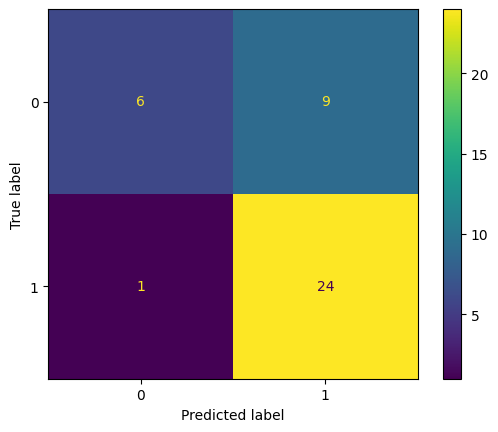

In [12]:
ConfusionMatrixDisplay(cm).plot();

#### Accuracy

$$
Accuracy = \frac{TP + TN}{Total}
$$

In [13]:
accuracy_score(y_true, y_predicted), (tp + tn) / (tp + tn + fp + fn)

(0.75, 0.75)

In [14]:
# manual calculation
(y_true == y_predicted).sum() / len(y_true)

0.75

#### Precision

$$
Precision = \frac{TP}{TP + FP}
$$

- The accuracy of positive predictions
- Out of all those that wee\re predicted to be positive (5s), what proportion did it get right?

In [15]:
precision_score(y_true, y_predicted), tp / (tp + fp)

(0.7272727272727273, 0.7272727272727273)

#### Recall

$$
Recall = \frac{TP}{TP + FN}
$$

- The ratio of positive instances that are correctly detected
- Also called sensitivity or TPR (True Positive Rate)
- Out of all those that were actually positive (5s), how many did it get right?

In [16]:
recall_score(y_true, y_predicted), tp / (tp + fn)

(0.96, 0.96)

#### F1 Score

$$
F1 = 2\times\frac{precision \times recall}{precision + recall}
$$

- The harmonic mean of precision and recall
- Ranges from 0 to 1, with 1 being the best score
- The F1 score favours classifiers that have similar precision and recall
    - sometimes you care more about one than the other

In [17]:
f1_score(y_true, y_predicted)

0.8275862068965517

In [18]:
precision = precision_score(y_true, y_predicted)
recall = recall_score(y_true, y_predicted)
2 * (precision * recall) / (precision + recall)

0.8275862068965517

#### Classification Report

In [19]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.40      0.55        15
           1       0.73      0.96      0.83        25

    accuracy                           0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



In [20]:
# pos_label is 0
precision_0, recall_0, f1_0 = (
    precision_score(y_true, y_predicted, pos_label=0),
    recall_score(y_true, y_predicted, pos_label=0),
    f1_score(y_true, y_predicted, pos_label=0)
)

precision_0, recall_0, f1_0

(0.8571428571428571, 0.4, 0.5454545454545455)

In [21]:
# pos_label is 1
precision_1, recall_1, f1_1 = (
    precision_score(y_true, y_predicted, pos_label=1),
    recall_score(y_true, y_predicted, pos_label=1),
    f1_score(y_true, y_predicted, pos_label=1)
)

precision_1, recall_1, f1_1

(0.7272727272727273, 0.96, 0.8275862068965517)

#### Log Loss

- Sometimes, the output of a classifier is **the probability of a class instead of the label**
    - for example, in logistic regression, the output can be the probability of customer churn
- `log_loss` measures the peformance of a classifier where the predicted output is a probability value between 0 and 1
- the following formula is the calculation for all rows

$$
-\frac{1}{n}\sum(y \, \times \, \log{(\widehat{y})} + (1 - y) \, \times \, \log{(1 - \widehat{y})})
$$

### 1.3.1.4 Lab: KNN

#### The Data

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case.

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns.

The target field, called **custcat**, has four possible values that correspond to the four customer groups, as follows:
1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

Our objective is to build a classifier, to predict the class of unknown cases. We will use a specific type of classification called K nearest neighbour.

In [22]:
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/'
data_url += 'IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/'
data_url += 'labs/Module%203/data/teleCust1000t.csv'

df = pd.read_csv(data_url)
df

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3,1
996,1,7,34,0,2,22.0,5,5,0.0,1,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1,4
998,3,70,49,0,18,87.0,2,22,0.0,1,1,3


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [24]:
df['custcat'].value_counts()

,count
custcat,
3,281
1,266
4,236
2,217


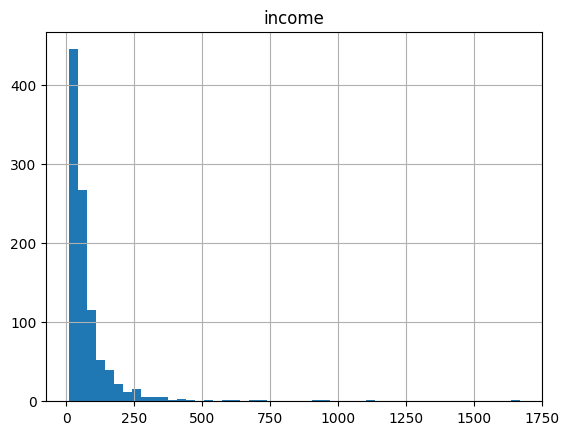

In [25]:
df.hist(column='income', bins=50);

In [26]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

In [27]:
X = df.drop('custcat', axis=1)
X

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
0,2,13,44,1,9,64.0,4,5,0.0,0,2
1,3,11,33,1,7,136.0,5,5,0.0,0,6
2,3,68,52,1,24,116.0,1,29,0.0,1,2
3,2,33,33,0,12,33.0,2,0,0.0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3
996,1,7,34,0,2,22.0,5,5,0.0,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1
998,3,70,49,0,18,87.0,2,22,0.0,1,1


In [28]:
y = df['custcat'].values
y

array([1, 4, 3, 1, 3, 3, 2, 4, 3, 2, 1, 3, 1, 4, 1, 2, 3, 3, 1, 4, 2, 1,
       4, 1, 3, 3, 4, 3, 1, 2, 2, 4, 3, 2, 4, 2, 4, 3, 3, 3, 3, 3, 1, 4,
       3, 2, 2, 4, 1, 3, 1, 2, 4, 1, 1, 1, 2, 1, 3, 2, 3, 4, 1, 4, 4, 1,
       3, 3, 1, 1, 1, 2, 1, 2, 3, 1, 3, 1, 3, 4, 4, 1, 4, 3, 2, 1, 2, 4,
       4, 3, 2, 1, 2, 4, 1, 4, 3, 2, 3, 2, 4, 3, 3, 2, 2, 2, 1, 4, 1, 2,
       2, 2, 1, 2, 3, 1, 3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 4, 2, 2, 4, 3, 1,
       4, 2, 3, 1, 1, 3, 3, 4, 4, 3, 4, 2, 3, 1, 4, 2, 2, 2, 1, 3, 4, 4,
       4, 3, 1, 1, 2, 3, 3, 3, 1, 3, 2, 2, 4, 1, 1, 2, 4, 1, 4, 1, 2, 1,
       3, 4, 4, 1, 4, 1, 2, 2, 2, 1, 1, 2, 3, 3, 1, 4, 2, 3, 4, 1, 1, 3,
       1, 4, 1, 4, 2, 2, 4, 1, 3, 4, 3, 3, 1, 1, 1, 2, 2, 1, 3, 4, 4, 1,
       3, 4, 1, 3, 1, 4, 4, 1, 3, 3, 3, 3, 2, 1, 4, 2, 4, 4, 1, 4, 1, 4,
       3, 2, 1, 3, 2, 1, 1, 2, 1, 4, 2, 2, 4, 3, 2, 1, 4, 4, 4, 1, 3, 2,
       1, 1, 3, 3, 3, 1, 3, 2, 4, 1, 3, 2, 2, 3, 3, 1, 4, 4, 3, 2, 3, 3,
       4, 3, 3, 2, 4, 3, 2, 3, 4, 4, 3, 1, 4, 2, 3,

#### Normalize Data

In [29]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-0.02696767, -1.055125  ,  0.18450456, ..., -0.22207644,
        -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243, ..., -0.22207644,
        -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601, ..., -0.22207644,
         0.96655883, -0.23065004],
       ...,
       [ 1.19883553,  1.47425216,  1.37948227, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  1.61477311,  0.58283046, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  0.67796676, -0.45281689, ..., -0.22207644,
         0.96655883,  0.46617787]])

#### Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 11), (200, 11), (800,), (200,))

#### Training and Predicting: `k=4`

In [31]:
k = 4

model4 = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
model4

KNeighborsClassifier(n_neighbors=4)

In [32]:
y_hat_4_train = model4.predict(X_train)
accuracy_score(y_train, y_hat_4_train), (y_train == y_hat_4_train).sum() / len(y_train)

(0.5475, 0.5475)

In [33]:
y_hat_4_test = model4.predict(X_test)
accuracy_score(y_test, y_hat_4_test), (y_test == y_hat_4_test).sum() / len(y_test)

(0.32, 0.32)

#### Training and Predicting: `k=6`

In [34]:
k = 6

model6 = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
model6

KNeighborsClassifier(n_neighbors=6)

In [35]:
y_hat_6_train = model6.predict(X_train)
accuracy_score(y_train, y_hat_6_train), (y_train == y_hat_6_train).sum() / len(y_train)

(0.51625, 0.51625)

In [36]:
y_hat_6_test = model4.predict(X_test)
accuracy_score(y_test, y_hat_6_test), (y_test == y_hat_6_test).sum() / len(y_test)

(0.32, 0.32)

#### More values for `k`

In [37]:
max_k = 10
ks = range(1, max_k + 1)
accuracy_scores = np.zeros(max_k)
standard_errors= np.zeros(max_k)

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    accuracy_scores[k-1] = accuracy_score(y_test, y_hat)
    standard_errors[k-1] = np.std(y_hat == y_test) / np.sqrt(y_hat.shape[0])

accuracy_scores, standard_errors


(array([0.3  , 0.29 , 0.315, 0.32 , 0.315, 0.31 , 0.335, 0.325, 0.34 ,
        0.33 ]),
 array([0.0324037 , 0.03208582, 0.03284623, 0.03298485, 0.03284623,
        0.03270321, 0.03337477, 0.0331191 , 0.03349627, 0.03324906]))

#### Plot Accuracy for different values of `k`

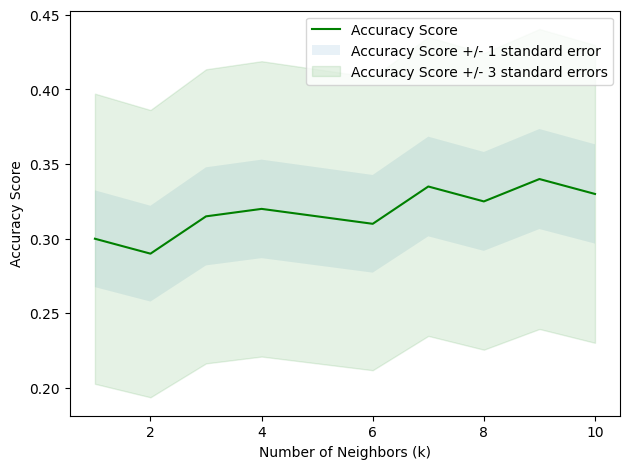

In [38]:
plt.plot(ks, accuracy_scores, 'g', label='Accuracy Score')
plt.fill_between(ks,
                 accuracy_scores - 1 * standard_errors,
                 accuracy_scores + 1 * standard_errors, alpha=0.1,
                 label='Accuracy Score +/- 1 standard error')
plt.fill_between(ks,
                 accuracy_scores - 3 * standard_errors,
                 accuracy_scores + 3 * standard_errors, alpha=0.1, color='green',
                 label='Accuracy Score +/- 3 standard errors')

plt.legend()
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.tight_layout()
plt.show()

In [39]:
print( "The best accuracy was with", accuracy_scores.max(), "with k=", accuracy_scores.argmax()+1)

The best accuracy was with 0.34 with k= 9


## 1.3.2 Decision Trees

### 1.3.2.1 Introduction to Decision Trees

- The basic intuition behind a decision treet is to map out all possible decision paths in the form of a tree

#### How to build a decision tree

- All your patients suffer from the same illness
- Each patient responded to one of two medications
    1. Drug A
    2. Drug B
- **Drug** is the target variable
- A **binary classifier** is needed

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/Decision1.png'/>

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/Decision2.png'/>

- Decision trees are built by splitting the training set into distince nodes, where one node contains all of, or most of, one category of the data
- In the above tree, we can see that this is a patient classifier
- We want to prescribe a drug to a patient, but the decision to choose drug A or B will be influenced by the patient's situation
- We start with Age, which can be:
    1. Young
    2. Middle-age
    3. Senior
    - If the patient is Middle-age, we will definitely go for Drug B
    - If he is Young or Senior, we need more details to help us determine which drug to prescribe
- Each **internal node** corresponds to a test
- Each **branch** corresponds to a result of the test
- Each **leaf node** assigns a patient to a class

#### Decision Tree Learning Algorithm

1. Choose an attribute from your dataset
2. Calculate the significance of the attribute in splitting the data
    - Covered in the next section: ***1.3.3 Building Decision Trees***
3. Split data based on the value of the best attribute
4. Go to each branch and repeat these steps for the rest of the attributes

After building this tree, you can use it to predict the class of unknown cases, in our case, the proper drug for a new patient based on his or her characteristics.

### 1.3.2.2 Building Decision Trees

#### How do you build a decision tree?

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/Decision3.png'/>



In [40]:
df = pd.DataFrame({'Patient_ID': ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
                                  'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14'],
                   'Age': ['Young', 'Young', 'Middle-age', 'Senior', 'Senior', 'Senior', 'Middle-age',
                           'Young', 'Young', 'Senior', 'Young', 'Middle-age', 'Middle-age', 'Senior'],
                   'Sex': ['F', 'F', 'F', 'F', 'M', 'M', 'M',
                           'F', 'M', 'M', 'M', 'F', 'M', 'F'],
                   'BP': ['High', 'High', 'High', 'Normal', 'Low', 'Low', 'Low',
                          'Normal', 'Low', 'Normal', 'Normal', 'Normal', 'High', 'Normal'],
                   'Cholesterol': ['Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'High',
                                   'Normal', 'Normal', 'Normal', 'High', 'High', 'Normal', 'High'],
                   'Drug': ['A', 'A', 'B', 'B', 'B', 'A', 'B',
                            'A', 'B', 'B', 'B', 'B', 'B', 'A']})

df

,Patient_ID,Age,Sex,BP,Cholesterol,Drug
0,p1,Young,F,High,Normal,A
1,p2,Young,F,High,High,A
2,p3,Middle-age,F,High,Normal,B
3,p4,Senior,F,Normal,Normal,B
4,p5,Senior,M,Low,Normal,B
5,p6,Senior,M,Low,High,A
6,p7,Middle-age,M,Low,High,B
7,p8,Young,F,Normal,Normal,A
8,p9,Young,M,Low,Normal,B
9,p10,Senior,M,Normal,Normal,B


#### Which attribute is best?

- Decision trees are built using recursive partioning to classify the data
- Let's say we have 14 patients in our dataset, the algorithm chooses the **most predictive feature** to split the data on
- Let's say we choose **Cholesterol** as the first attribute to split the data

In [41]:
df.groupby(['Cholesterol', 'Drug'])['Patient_ID'].count()

Cholesterol  Drug
High         A       3
             B       3
Normal       A       2
             B       6
Name: Patient_ID, dtype: int64

- Let's try **Sex**
    - This is a better choice than **Cholesterol**
        - More **Predictiveness**
            - Less **Impurity**
            - Lower **Entropy**

In [42]:
df.groupby(['Sex', 'Drug'])['Patient_ID'].count()

Sex  Drug
F    A       4
     B       3
M    A       1
     B       6
Name: Patient_ID, dtype: int64

- Let's try **Sex**, followed by **Cholesterol**
- If we follow the tree: Male $\rightarrow$ Normal $\rightarrow$ Pure Leaf
    - All 4 patients were treated with Drug B, which has no impurity
- A node is considered **Pure**, if in 100% of the cases, the nodes fall into a specific class in the target field

In [43]:
df.groupby(['Sex', 'Cholesterol', 'Drug'])['Patient_ID'].count()

Sex  Cholesterol  Drug
F    High         A       2
                  B       1
     Normal       A       2
                  B       2
M    High         A       1
                  B       2
     Normal       B       4
Name: Patient_ID, dtype: int64

- The algorithm uses recursive partioning to split the training records into segments by minimizing the impurity at each step

#### What is Entropy?

- **Entropy** is the amount of information disorder, or the amount of randomness in the data
- The entropy is calculated for each node
- In decision trees, we're looking for trees that have the smallest entropy in their nodes
- The lower the entropy, the less uniform the distribution, the purer the node
- The entropy is used calculate the homogeneity of the samples in that node
    - If the samples are completely homogeneous, the entropy is equal to 0
    - If the samples are equally divided, the entropy is equal to 1

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/entropy.png'/>

- $p$ is the proportion or ratio of a category

$$
Entropy = -p(A)\log_{2}(p(A)) - p(B)\log_{2}(p(B))
$$

- Let's calcuate the entropy of the dataset before splitting it

In [44]:
def entropy(num_A, num_B):
    total = num_A + num_B
    pA = num_A / total
    pB = num_B / total
    entrpy = - pA * np.log2(pA) - pB * np.log2(pB)
    return entrpy

entropy_p = lambda p: - p * np.log2(p) - (1-p) * np.log2(1-p)

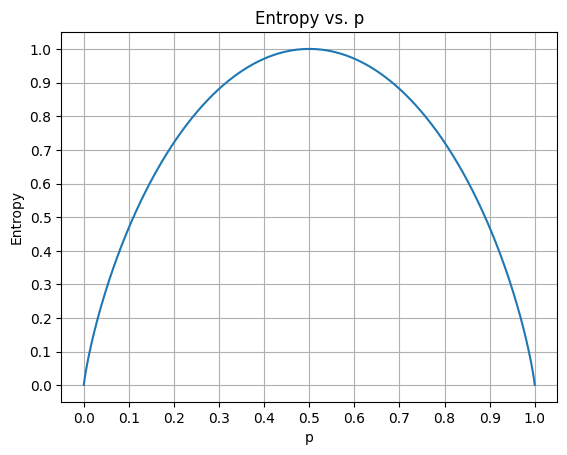

In [45]:
x = np.linspace(0, 1, 10000)
xticks = np.linspace(0, 1, 11)
yticks = xticks

# avoids division by zero
x = x[1:-1]

plt.plot(x, entropy_p(x))
plt.xlabel('p')
plt.ylabel('Entropy')
plt.title('Entropy vs. p')
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid()
plt.show()

In [46]:
num_A, num_B = df['Drug'].value_counts().sort_index().values
entropy(num_A, num_B)

0.9402859586706311

- Let's caculate the entropy after splitting on cholesterol

In [47]:
high_A, high_B, normal_A, normal_B = df.groupby(['Cholesterol', 'Drug']) \
 ['Patient_ID'].count().sort_index(level=[0,1]).values

high_A, high_B, normal_A, normal_B

(3, 3, 2, 6)

In [48]:
entropy_normal = entropy(normal_A, normal_B)
entropy_high = entropy(high_A, high_B)
entropy_normal, entropy_high

(0.8112781244591328, 1.0)

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/entropy2.png'/>

- Splitting on sex

In [49]:
female_A, female_B, male_A, male_B = df.groupby(['Sex', 'Drug']) \
['Patient_ID'].count().sort_index(level=[0,1]).values

entropy_F = entropy(female_A, female_B)
entropy_M = entropy(male_A, male_B)
entropy_F, entropy_M

(0.9852281360342515, 0.5916727785823275)

#### Split by `Sex` or `Cholesterol`?

- Choose the tree with the higher **Information Gain** after splitting
- **Information Gain** is the information that can increase the level of certainty after splitting

##### **Information Gain = (Entropy before split) - (weighted entropy after split)**

- As weighted entropy decreases, information gain increases

$$
\begin{align}
Gain(s, Sex) &= 0.94 - \left(\frac{7}{14} \times 0.985 \;+\; \frac{7}{14} \times 0.592 \right) \\
&= 0.151
\end{align}
$$

$$
\begin{align}
Gain(s, Cholesterol) &= 0.94 - \left(\frac{8}{14} \times 0.811 \;+\; \frac{6}{14} \times 1\right) \\
&= 0.048
\end{align}
$$

- The `Sex` split has more information gain


<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/entropy3.png'/>

 #### ChatGPT Question

 In a decision tree, choosing the attribute with the highest information gain (or equivalently the highest reduction in entropy) at the first split is often a strong heuristic for building the tree. However, it is not always guaranteed that this will lead to the optimal final model. Here’s why:

1. Greedy Nature of Decision Trees:

Decision trees are constructed using a greedy algorithm, which means that at each step (or split), the algorithm selects the feature that provides the highest immediate information gain. However, this approach only considers the local impact of the current split and ignores how future splits could influence the final tree.

2. Possible Suboptimal Splits:

There are cases where choosing a feature with less immediate information gain in the first split could lead to a better overall tree after subsequent splits. This is because:

- A feature that doesn’t provide the highest information gain on the first split might enable more meaningful splits later in the tree.
- A split with slightly lower initial information gain might partition the data in a way that sets up more distinct or better groupings in the following levels, ultimately leading to a better classification performance.

3. Overfitting and Tree Depth:

Choosing the attribute with the highest information gain early on could lead to deeper trees that overfit the training data. On the other hand, sometimes less informative early splits can balance the tree better and lead to improved generalization on unseen data.

4. Lookahead Strategies:

Some advanced decision tree algorithms consider lookahead strategies, where instead of just making decisions based on immediate information gain, the algorithm evaluates the future potential of splits (e.g., by simulating several levels of splits ahead). This method can avoid locally optimal splits that don’t lead to good global performance.

5. Regularization and Pruning:

Decision trees are prone to overfitting when using greedy heuristics like information gain. Post-hoc pruning techniques or regularization methods (such as limiting tree depth) help mitigate this risk by removing branches or limiting growth, which in turn can reduce the reliance on the highest immediate information gain for the first split.

Conclusion:

While selecting the attribute with the highest information gain for the first split is often effective, it is not guaranteed to always be the best long-term choice. In some cases, a feature with slightly lower information gain may lead to a better final model after subsequent splits. This happens because the decision tree algorithm is locally greedy and does not always account for the global structure of the tree. Alternative strategies, like lookahead methods or post-pruning, can help mitigate this limitation.

#### Example

In [50]:
import graphviz
from sklearn.tree import export_graphviz

In [51]:
ord_enc = OrdinalEncoder()
X = ord_enc.fit_transform(df[['Sex']])

#y = df['Drug'].copy()
ord_enc.categories_, X[:5]

([array(['F', 'M'], dtype=object)],
 array([[0.],
        [0.],
        [0.],
        [0.],
        [1.]]))

In [52]:
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df['Drug'])

lb_enc.classes_, y[:]

(array(['A', 'B'], dtype=object),
 array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]))

In [53]:
d_tree0 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
d_tree0

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [54]:
d_tree0.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

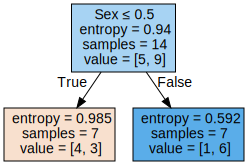

In [55]:
viz = export_graphviz(d_tree0,
                      out_file=None,
                      feature_names=['Sex'],
                      filled=True,
                      special_characters=True)
graphviz.Source(viz)

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/entropy4.png'/>

In [56]:
d_tree1 = DecisionTreeClassifier(max_depth=1)
d_tree1

DecisionTreeClassifier(max_depth=1)

In [57]:
d_tree1.fit(X, y)

DecisionTreeClassifier(max_depth=1)

- **Gini** is another measure of impurity
     - In binary classification, Gini ranges from 0 (pure) to 0.5 (maximum impurity)
    - It measures the probability of misclassification
    - **Gini** is favoured for its simplicity and speed
    - **Information Gain (based on Entropy)** is favoured because it is slightly more precise in handling uncertainty in the data
- $p$ is the probability of one class
- $(1 - p)$ is the probability of the other class

$$
Gini(p) = 1 - p^{2} - (1 - p)^{2}
$$

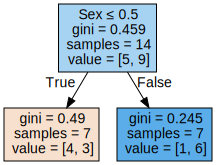

In [58]:
viz = export_graphviz(d_tree1,
                      out_file=None,
                      feature_names=['Sex'],
                      filled=True,
                      special_characters=True)
graphviz.Source(viz)

In [59]:
gini1 = 1 - (5/14)**2 - (1 - (5/14))**2
gini2 = 1 - (4/7)**2 - (1 - (4/7))**2
gini3 = 1 - (1/7)**2 - (1 - (1/7))**2
gini1, gini2, gini3

(0.4591836734693879, 0.489795918367347, 0.2448979591836733)

### 1.3.2.3 Lab: Decision Trees

#### The Data

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

In [60]:
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/'
data_url += 'IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/'
data_url += 'labs/Module%203/data/drug200.csv'

df2 = pd.read_csv(data_url)
df2

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [61]:
df2.shape

(200, 6)

In [62]:
X = df2.drop('Drug', axis=1)
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [63]:
y = df2['Drug']
y.head()

,Drug
0,drugY
1,drugC
2,drugC
3,drugX
4,drugY


As you may figure out, some features in this dataset are categorical, such as **Sex** or **BP**. Unfortunately, Sklearn Decision Trees does not handle categorical variables. We can still convert these features to numerical values using the **LabelEncoder() method**
to convert the categorical variable into dummy/indicator variables.

In [64]:
ord_enc = OrdinalEncoder()
X[['Sex', 'BP', 'Cholesterol']] = ord_enc.fit_transform(X[['Sex', 'BP', 'Cholesterol']])
ord_enc.categories_

[array(['F', 'M'], dtype=object),
 array(['HIGH', 'LOW', 'NORMAL'], dtype=object),
 array(['HIGH', 'NORMAL'], dtype=object)]

In [65]:
X

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0.0,0.0,0.0,25.355
1,47,1.0,1.0,0.0,13.093
2,47,1.0,1.0,0.0,10.114
3,28,0.0,2.0,0.0,7.798
4,61,0.0,1.0,0.0,18.043
...,...,...,...,...,...
195,56,0.0,1.0,0.0,11.567
196,16,1.0,1.0,0.0,12.006
197,52,1.0,2.0,0.0,9.894
198,23,1.0,2.0,1.0,14.020


#### Setting up the Decision Tree

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140, 5), (60, 5), (140,), (60,))

#### Modeling

In [67]:
drugTree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
drugTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [68]:
drugTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

#### Prediction

In [69]:
predictions = drugTree.predict(X_test)
predictions

array(['drugY', 'drugX', 'drugX', 'drugX', 'drugX', 'drugC', 'drugY',
       'drugA', 'drugB', 'drugA', 'drugY', 'drugA', 'drugY', 'drugY',
       'drugX', 'drugY', 'drugX', 'drugX', 'drugB', 'drugX', 'drugX',
       'drugY', 'drugY', 'drugY', 'drugX', 'drugB', 'drugY', 'drugY',
       'drugA', 'drugX', 'drugB', 'drugC', 'drugC', 'drugX', 'drugX',
       'drugC', 'drugY', 'drugX', 'drugX', 'drugX', 'drugA', 'drugY',
       'drugC', 'drugY', 'drugA', 'drugY', 'drugY', 'drugY', 'drugY',
       'drugY', 'drugB', 'drugX', 'drugY', 'drugX', 'drugY', 'drugY',
       'drugA', 'drugX', 'drugY', 'drugX'], dtype=object)

In [70]:
print(predictions[0:5])
print(y_test[0:5])

['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


#### Evaluation

In [71]:
accuracy_score(y_test, predictions)

0.9833333333333333

In [72]:
# manually
(y_test == predictions).sum() / len(y_test)

0.9833333333333333

#### Visualization

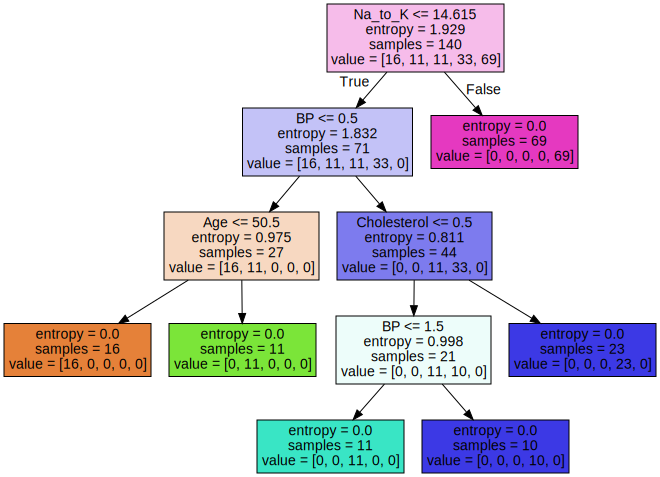

In [73]:
viz = export_graphviz(drugTree,
                      out_file=None,
                      feature_names=drugTree.feature_names_in_,
                      filled=True)

graphviz.Source(viz)

#### Again with 'gini'

In [74]:
drugTree = DecisionTreeClassifier(criterion='gini', max_depth=4)
drugTree

DecisionTreeClassifier(max_depth=4)

In [75]:
drugTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [76]:
accuracy_score(y_test, predictions)

0.9833333333333333

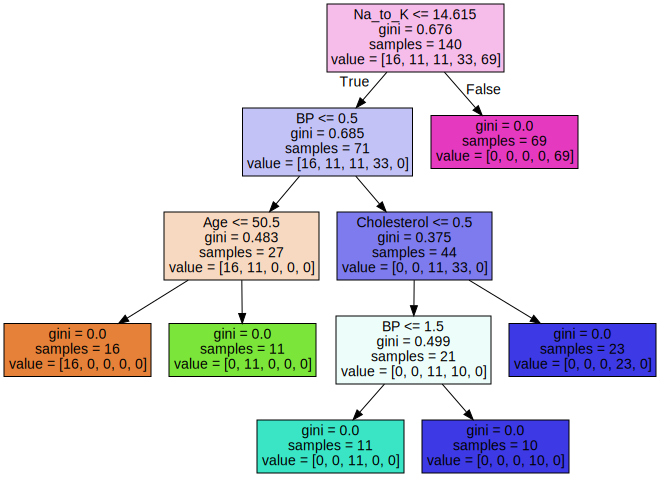

In [77]:
viz = export_graphviz(drugTree,
                      out_file=None,
                      feature_names=drugTree.feature_names_in_,
                      filled=True)

graphviz.Source(viz)

### 1.3.2.4 Lab: Faster Credit Card Fraud Detection using Snap ML

In this exercise session you will consolidate your machine learning (ML) modeling skills by using two popular classification models to recognize fraudulent credit card transactions. These models are: Decision Tree and Support Vector Machine. You will use a real dataset to train each of these models. The dataset includes information about
transactions made by credit cards in September 2013 by European cardholders. You will use the trained model to assess if a credit card transaction is legitimate or not.

In the current exercise session, you will practice not only the Scikit-Learn Python interface, but also the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy. For more information, please visit [snapml](https://ibm.biz/BdPfxy) information page.

#### Introduction

Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).

You have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically you have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).

This is a Kaggle dataset. You can find this "Credit Card Fraud Detection" dataset from the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Credit Card Fraud Detection</a>

To train the model, you can use part of the input dataset, while the remaining data can be utilized to assess the quality of the trained model. First, let's import the necessary libraries and download the dataset.


#### The Data

In [78]:
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/'
data_url += 'IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/'
data_url += 'data/creditcard.csv'

raw_data = pd.read_csv(data_url)
raw_data.shape

(284807, 31)

#### Dataset Analysis

In [79]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [80]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.

In [81]:
test = np.array([1, 2, 3])
test

array([1, 2, 3])

In [82]:
np.repeat(test, 10, axis=0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [83]:
n_replicas = 10

big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)
big_raw_data.shape

(2848070, 31)

In [84]:
big_raw_data.head(12)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
5,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
6,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
7,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
8,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
9,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


In [85]:
big_raw_data['Class'].value_counts()

,count
Class,
0.0,2843150
1.0,4920


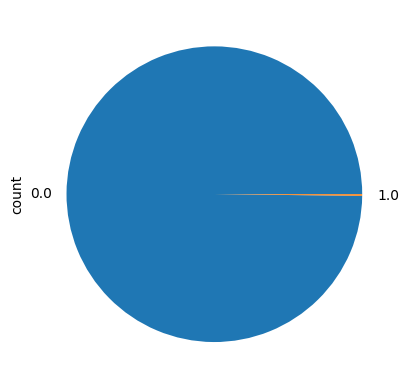

In [86]:
big_raw_data['Class'].value_counts().plot(kind='pie');

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

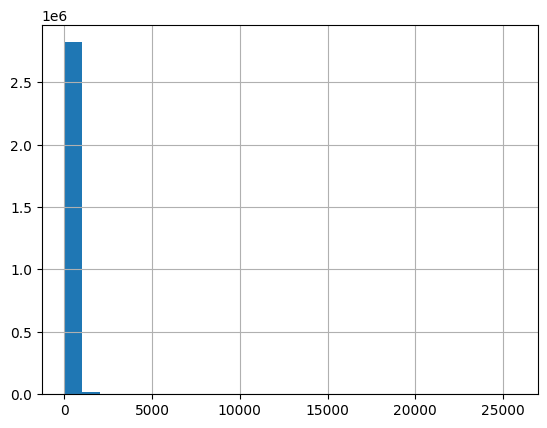

In [87]:
big_raw_data['Amount'].hist(bins=25);

In [88]:
np.min(big_raw_data['Amount']), np.max(big_raw_data['Amount'])

(0.0, 25691.16)

In [89]:
print('90% of the transactions have an amount less than ', np.percentile(big_raw_data['Amount'], 90))

90% of the transactions have an amount less than  203.0


#### Data Preprocessing

In [90]:
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
big_raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
1,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
2,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
3,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
4,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0


In [91]:
X = big_raw_data.iloc[:, 1:30]
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964
1,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964
2,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964
3,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964
4,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964


In [92]:
y = big_raw_data.iloc[:, 30].values
y

array([0., 0., 0., ..., 0., 0., 0.])

In [93]:
X = normalize(X, norm='l1')

In [94]:
X.shape, y.shape

((2848070, 29), (2848070,))

#### Train Test Split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1993649, 29), (854421, 29), (1993649,), (854421,))

In [96]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1.]), array([1990205,    3444])),
 (array([0., 1.]), array([852945,   1476])))

#### Build a Decision Tree Classifier with Scikit-Learn

In [97]:
# from sklearn.utils.class_weight import compute_sample_weight

# compute the sample weights to be used as input to the train routine so that
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)
w_train.shape, y_train.shape

((1993649,), (1993649,))

In [98]:
np.unique(w_train, return_counts=True)

(array([  0.50086524, 289.43800813]), array([1990205,    3444]))

In [99]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([1990205,    3444]))

In [100]:
first_weight, second_weight = np.unique(w_train)
first_count, second_count = np.unique(y_train, return_counts=True)[1]
first_weight, second_weight, first_count, second_count

(0.5008652375006595, 289.4380081300813, 1990205, 3444)

In [101]:
first_weight * first_count, second_weight * second_count

(996824.5, 996824.5)

In [102]:
w_train[:10], y_train[:10]

(array([0.50086524, 0.50086524, 0.50086524, 0.50086524, 0.50086524,
        0.50086524, 0.50086524, 0.50086524, 0.50086524, 0.50086524]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [103]:
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)
sklearn_dt

DecisionTreeClassifier(max_depth=4, random_state=35)

In [104]:
# training
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  56.26014


#### Build a Decision Tree Classifier model with Snap ML

In [105]:
w_train # from above

array([0.50086524, 0.50086524, 0.50086524, ..., 0.50086524, 0.50086524,
       0.50086524])

In [106]:
!pip install snapml

In [107]:
from snapml import DecisionTreeClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [108]:
# Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn
# to use the GPU, set the use_gpu parameter to True
# snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)
snapml_dt

DecisionTreeClassifier(max_depth=4, n_jobs=4, random_state=45)

In [109]:
# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  7.53737


#### Evaluate the Scikit-Learn and Snap ML Decision Tree Classifier Models

In [110]:
sklearn_time, snapml_time

(56.260135889053345, 7.537370204925537)

In [111]:
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 7.46x 


In [112]:
# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
sklearn_pred_proba = sklearn_dt.predict_proba(X_test)[:, 1]
sklearn_pred_proba

array([0.03947781, 0.09088916, 0.03947781, ..., 0.03947781, 0.03947781,
       0.03947781])

In [113]:
# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred_proba)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

[Scikit-Learn] ROC-AUC score : 0.966


In [114]:
# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred_proba = snapml_dt.predict_proba(X_test)[:,1]
snapml_pred_proba

array([0.03965165, 0.09108091, 0.03965165, ..., 0.03965165, 0.03965165,
       0.03965165])

In [115]:
# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred_proba)
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Snap ML] ROC-AUC score : 0.966


As shown above both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine faster than Scikit-Learn. This is one of the advantages of using Snap ML: acceleration of training of classical machine learning models, such as linear and tree-based models. For more Snap ML examples, please visit [snapml-examples](https://ibm.biz/BdPfxP).

#### Build a Support Vector Machine model with Scikit-Learn

In [116]:
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
sklearn_svm

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

In [117]:
# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Scikit-Learn] Training time (s):  105.18


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Build a Support Vector Machine model with Snap ML

In [118]:
from snapml import SupportVectorMachine

In [119]:
# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())
snapml_svm

SupportVectorMachine(class_weight='balanced', n_jobs=4, random_state=25)

In [120]:
# train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  17.46


#### Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models

In [121]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 6.03x 


In [122]:
# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
sklearn_pred

array([-1.00221515, -0.56524071, -1.65588761, ..., -1.40925415,
       -1.40351212, -0.95381137])

In [123]:
# run inference using the Snap ML model
# get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)
snapml_pred

array([-0.95150606, -0.56282718, -1.62834246, ..., -1.38096734,
       -1.4460759 , -0.95618071])

In [124]:
# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

# evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


As shown above both SVM models provide the same score on the test dataset. However, as in the case of decision trees, Snap ML runs the training routine faster than Scikit-Learn. For more Snap ML examples, please visit [snapml-examples](https://ibm.biz/BdPfxP). Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.

In [125]:
# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))

# the two models should give the same Hinge loss

[Snap ML] Hinge loss:   0.228
[Scikit-Learn] Hinge loss:   0.228


### 1.3.2.5 Regression Trees

As we have already seen, decision trees can be used for classification, but we can also use them for regression, commonly called regression trees.

The basic idea behind regression trees is to split our data into groups based on features, like in classification, and return a prediction that is the average across the data we have already seen.

Consider the housing data below, where we are using the ‘Age’ to predict the ‘Price’ of a house.

In [126]:
housing = pd.DataFrame({'Age': [1, 2, 5, 7, 7, 15, 39, 45, 32, 21, 55, 64, 75, 62, 79],
                        'Price': [515550.73, 491775.83, 457544.34, 506443.94,
                                  524594.98, 368796.62, 362740.81, 361467.51,
                                  411260.00, 390396.54, 94761.54, 115555.98,
                                  73275.04, 116153.90, 135408.55]})
housing

,Age,Price
0,1,515550.73
1,2,491775.83
2,5,457544.34
3,7,506443.94
4,7,524594.98
5,15,368796.62
6,39,362740.81
7,45,361467.51
8,32,411260.00
9,21,390396.54


Text(0, 0.5, 'Price ($)')

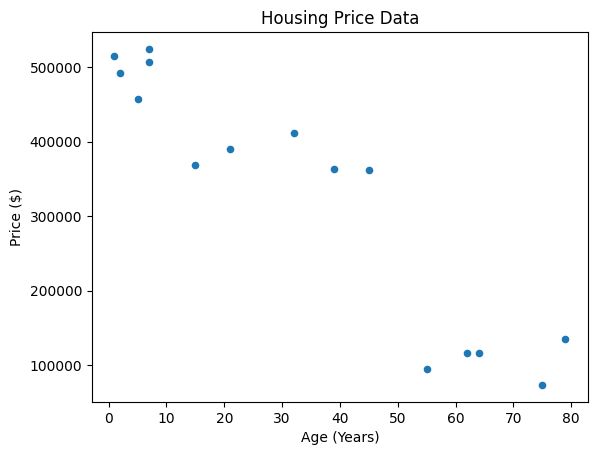

In [127]:
housing.plot(kind='scatter', x='Age', y='Price')
plt.title('Housing Price Data')
plt.xlabel('Age (Years)')
plt.ylabel('Price ($)')

Using the data above, we can create the regression tree, as shown below. The prices were determined by calculating the average price of the houses in the age range.

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/tree1.png'/>

In [128]:
age_less_than_10 = housing[housing['Age'] < 10]
age_less_than_10['Price'].mean()

499181.96400000004

In [129]:
age_greater_than_or_equal_10 = housing[housing['Age'] >= 10]
age_less_than_50 = age_greater_than_or_equal_10[age_greater_than_or_equal_10['Age'] < 50]
age_less_than_50['Price'].mean()

378932.296

In [130]:
age_greater_than_or_equal_50 = age_greater_than_or_equal_10[age_greater_than_or_equal_10['Age'] >= 50]
age_greater_than_or_equal_50['Price'].mean()

107031.00200000001

##### Criterion

The way the trees are built are similar to classification, but instead of using the entropy criterion. In Classification Trees, we choose features that increase the information gain. In Regression Trees, we choose features that minimize the error.

A popular one is the Mean Absolute Error, which we have also seen previously.

$$
MAE = \frac{1}{n}\sum_{i=1}^{n}\lvert y_{i} - \widehat{y}_{i}\rvert
$$

##### How Regression Trees are Built

Take the dataset sample shown below, the first step is to decide what the first decision is. We will do this by using the criterion and checking every single feature in the dataset to see which one produces the minimal error.

In [131]:
df = pd.DataFrame({
    'Near_Water': ['No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
    'Age': [0, 45, 60, 20, 90, 100, 5, 10, 55, 25],
    'Price': [260831.34, 222939.35, 101882.10, 226868.52, 94868.94,
              197703.55, 347982.98, 343150.38, 206713.16, 329768.77]
})

df

,Near_Water,Age,Price
0,No,0,260831.34
1,No,45,222939.35
2,No,60,101882.10
3,No,20,226868.52
4,No,90,94868.94
5,Yes,100,197703.55
6,Yes,5,347982.98
7,Yes,10,343150.38
8,Yes,55,206713.16
9,Yes,25,329768.77


#### Categorical Features
Categorical features are simple, here we have Near Water so all we need to do is calculate the error if we used this as the first feature. Near Water feature has two categories: ‘Yes’ and ‘No’, therefore, we must calculate the average ‘Price’ of houses in the ‘Yes’ and ‘No’ categories. Then we use those values to calculate the average error.

In [132]:
near_water_no = df[df['Near_Water'] == 'No']
near_water_yes = df[df['Near_Water'] == 'Yes']

In [133]:
near_water_no['Price'].mean(), near_water_yes['Price'].mean()

(181478.05, 285063.76800000004)

In [134]:
near_water_no_absolute_error = np.abs(near_water_no['Price'] - near_water_no['Price'].mean())
near_water_yes_absolute_error = np.abs(near_water_yes['Price'] - near_water_yes['Price'].mean())
near_water_no_absolute_error, near_water_yes_absolute_error

(0    79353.29
 1    41461.30
 2    79595.95
 3    45390.47
 4    86609.11
 Name: Price, dtype: float64,
 5    87360.218
 6    62919.212
 7    58086.612
 8    78350.608
 9    44705.002
 Name: Price, dtype: float64)

In [135]:
near_water_no_mae = near_water_no_absolute_error.sum()
near_water_yes_mae = near_water_yes_absolute_error.sum()
near_water_mae = near_water_no_mae + near_water_yes_mae
near_water_mae

663831.772

#### Numerical Features

Numerical features, like ‘Age’, are trickier to handle because we need to find a number, instead of using a category, to split the data by. We do this by creating a boundary between each point, then we calculate the error.

For example, first we create the boundary between the first two data points, which are (0, 260831.34) and (5, 347982.98), so we create a boundary of x = 2.5 (The midpoint between the x component of the first two data points). We now find the average price of the houses on the left and right sides of this boundary and use it to calculate the MAE.

In [136]:
df.sort_values(by='Age', inplace=True)

In [137]:
df

,Near_Water,Age,Price
0,No,0,260831.34
6,Yes,5,347982.98
7,Yes,10,343150.38
3,No,20,226868.52
9,Yes,25,329768.77
1,No,45,222939.35
8,Yes,55,206713.16
2,No,60,101882.10
4,No,90,94868.94
5,Yes,100,197703.55


In [138]:
results = []
for age1, age2 in zip(df['Age'].values, df['Age'].values[1:]):
    split_age = np.mean([age1, age2])
    df1 = df[df['Age'] < split_age]
    df2 = df[df['Age'] >= split_age]
    absolute_error1 = np.abs(df1['Price'] - df1['Price'].mean())
    absolute_error2 = np.abs(df2['Price'] - df2['Price'].mean())
    mae1 = absolute_error1.sum()
    mae2 = absolute_error2.sum()
    result = (split_age, (mae1 + mae2).round(2))
    results.append(result)

results.sort(key = lambda x: x[1])

In [139]:
results

[(35.0, 497265.47),
 (15.0, 508475.17),
 (57.5, 512880.63),
 (50.0, 517928.59),
 (22.5, 579182.0),
 (7.5, 608710.91),
 (75.0, 626164.95),
 (2.5, 660552.43),
 (95.0, 665684.24)]

- The boundary `35` results in the lowest MAE
- Our categorical MAE was `663831.772`
- So, for the first decision we should use the numerical `Age` feature
- Here is our tree so far:

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/split1.png'/>

In [140]:
df = pd.DataFrame({
    'Near_Water': ['No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
    'Age': [0, 45, 60, 20, 90, 100, 5, 10, 55, 25],
    'Price': [260831.34, 222939.35, 101882.10, 226868.52, 94868.94,
              197703.55, 347982.98, 343150.38, 206713.16, 329768.77]
})

df

,Near_Water,Age,Price
0,No,0,260831.34
1,No,45,222939.35
2,No,60,101882.10
3,No,20,226868.52
4,No,90,94868.94
5,Yes,100,197703.55
6,Yes,5,347982.98
7,Yes,10,343150.38
8,Yes,55,206713.16
9,Yes,25,329768.77


In [141]:
df_less_than_35 = df[df['Age'] < 35]
df_35_or_greater = df[df['Age'] >= 35]
df_less_than_35.shape, df_35_or_greater.shape

((5, 3), (5, 3))

#### When do we Stop?

With the regression tree above, we have two options, we can either stop here and use the average value of the ‘Yes’ (left) and ‘No’ (right) to predict the house prices, or we can continue to add more decisions to either branch. There are a few conditions that are commonly used to stop growing regression trees:

- Tree depth
- Number of remaining samples on a branch
- Number of samples on each branch if another decision is made

The depth of the tree above, is 1, because there is a single decision and the number of samples on each side is 5. Let’s add more decisions until the depth of the tree is 2. First, we start with the ‘Yes’ (left) side and we calculate the MAE for the features using the houses that have ‘Age’ < 35.

#### Adding Decisions

- First we split the left side using the `Near_Water` feature

In [142]:
df_less_than_35_near_water_no = df_less_than_35[df_less_than_35['Near_Water'] == 'No']
df_less_than_35_near_water_yes = df_less_than_35[df_less_than_35['Near_Water'] == 'Yes']

df_less_than_35_near_water_no['Price'].mean(), df_less_than_35_near_water_yes['Price'].mean()

(243849.93, 340300.71)

- Split the right side using `Age < 57.5`

In [143]:
df_less_than_57_5 = df_35_or_greater[df_35_or_greater['Age'] < 57.5]
df_57_5_or_greater = df_35_or_greater[df_35_or_greater['Age'] >= 57.5]

df_less_than_57_5['Price'].mean(), df_57_5_or_greater['Price'].mean()

(214826.255, 131484.8633333333)

#### Final Result

<img src='https://raw.githubusercontent.com/PaulToronto/IBM---AI-Engineering-Professional-Certificate/refs/heads/main/images/tree_final.png'/>

### 1.3.2.6 Lab - Regression Trees

In this lab you will learn how to implement regression trees using ScikitLearn. We will show what parameters are important, how to train a regression tree, and finally how to determine our regression trees accuracy.

#### The Data

Imagine you are a data scientist working for a real estate company that is planning to invest in Boston real estate. You have collected information about various areas of Boston and are tasked with created a model that can predict the median price of houses for that area so it can be used to make offers.

The dataset had information on areas/towns not individual houses, the features are

- **CRIM**: Crime per capita
- **ZN**: Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: Proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: Nitric oxides concentration (parts per 10 million)
- **RM**: Average number of rooms per dwelling
- **AGE**: Proportion of owner-occupied units built prior to 1940
- **DIS**: Weighted distances to ﬁve Boston employment centers
- **RAD**: Index of accessibility to radial highways
- **TAX**: Full-value property-tax rate per 10,000 dollars
- **PTRAIO**: Pupil-teacher ratio by town
- **LSTAT**: Percent lower status of the population
- **MEDV**: Median value of owner-occupied homes in $1000s


In [144]:
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/'
data_url += 'IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/'
data_url += 'labs/Module%203/data/real_estate_data.csv'

data = pd.read_csv(data_url)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [145]:
data.shape

(506, 13)

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    486 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB


In [147]:
data.isna().sum()

,0
CRIM,20
ZN,20
INDUS,20
CHAS,20
NOX,0
RM,0
AGE,20
DIS,0
RAD,0
TAX,0


#### Data Preprocessing

In [148]:
# drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 0 to 504
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     394 non-null    float64
 1   ZN       394 non-null    float64
 2   INDUS    394 non-null    float64
 3   CHAS     394 non-null    float64
 4   NOX      394 non-null    float64
 5   RM       394 non-null    float64
 6   AGE      394 non-null    float64
 7   DIS      394 non-null    float64
 8   RAD      394 non-null    int64  
 9   TAX      394 non-null    int64  
 10  PTRATIO  394 non-null    float64
 11  LSTAT    394 non-null    float64
 12  MEDV     394 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 43.1 KB


In [149]:
X = data.drop('MEDV', axis=1)
y = data['MEDV']

#### Train Test Split

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((315, 12), (79, 12), (315,), (79,))

#### Create Regression Tree

The important parameters of `DecisionTreeRegressor` are

- `criterion`:  {"squared_error", "friedman_mse", "absolute_error",   "poisson"} - The function used to measure error
- `max_depth` - The max depth the tree can be
- `min_samples_split` - The minimum number of samples required to split a node
- `min_samples_leaf` - The minimum number of samples that a leaf can contain
- `max_features`: {"auto", "sqrt", "log2"} - The number of feature we examine looking for the best one, used to speed up training

In [151]:
regression_tree = DecisionTreeRegressor(criterion='squared_error')
regression_tree

DecisionTreeRegressor()

#### Training

In [152]:
regression_tree.fit(X_train, y_train)

DecisionTreeRegressor()

#### Evaluation

To evaluate our dataset we will use the `score` method of the `DecisionTreeRegressor` object providing our testing data, this number is the $R^2$ value which indicates the coefficient of determination

In [153]:
regression_tree.score(X_test, y_test)

0.8058491351002188

In [154]:
predictions = regression_tree.predict(X_test)
predictions

array([21.4, 21. , 28.7, 10.4, 12.7, 22.8, 24.1, 16.1, 30.3, 23.9, 28.6,
       21.6, 22.6, 35.1, 22.6, 31.6, 22.6, 21.4, 22.8, 32.7, 23.1, 20.6,
       38.7, 23.6, 20.4, 48.5, 14.8, 30.1, 19.5, 10.4, 22.5, 11.7, 19.8,
       31.6, 27.1,  7. , 28.6, 26.5, 19.1, 17.9, 19.4, 24.1, 20.3, 19.2,
       27.1,  5. , 24.6, 22.4, 11.7, 28.6, 22.2, 35.2, 20. ,  8.8, 22.4,
       24.1, 36.5, 19.3, 23.1, 17.2, 24.3, 19.1, 18.6, 35.1, 23.2, 34.9,
       16.6, 20. , 20.7, 18.2, 42.3, 14.6, 18.7, 28.1, 44.8, 24.8, 43.1,
       21.4, 21.4])

In [155]:
# average error in $
(predictions - y_test).abs().mean() * 1000

2792.405063291139

#### Exercise

Train a regression tree using the `criterion` `mae` then report its $R^2$ value and average error

In [156]:
regression_tree2 = DecisionTreeRegressor(criterion='absolute_error')
regression_tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error')

In [157]:
regression_tree2.score(X_test, y_test)

0.6910882850868114

In [158]:
predictions2 = regression_tree2.predict(X_test)
predictions2

array([18.2, 22.2, 29. , 10.4, 14.1, 14.5, 26.6, 17.4, 32.7, 23.1, 28.4,
       22.2, 24. , 29.9, 22.5, 31.5, 23.1, 21.8, 28.7, 36.1, 22.1, 20.6,
       38.7, 50. , 20.7, 50. , 19.9, 23.6, 16.8,  7. , 23.9, 11.7, 14.5,
       29.9, 27.1,  8.7, 26.6, 24.5, 19.1, 17.2, 18.2, 24.5, 19. , 18. ,
       27.1,  8.7, 24.6, 19. , 11.7, 27.1, 22.2, 35.2, 21.7,  8.7, 22.5,
       26.5, 37.2, 19.3, 17.1, 14.5, 21.6, 19.1, 21.7, 28.5, 20.7, 34.9,
       19.6, 19.4, 23.9, 18.9, 43.5, 14.1, 19.5, 19.6, 44.8, 27.1, 42.3,
       21.2, 21.8])

In [159]:
# average error in $
(predictions2 - y_test).abs().mean() * 1000

3037.9746835443034

### 1.3.2.7 Lab - Faster Taxi Tip Prediction using Snap ML